
## Time Series Forecast on a sample 'Google Trends' data using SARIMA algorithm


### Problem Statement

Google Trends is a website by Google that analyzes the popularity of top search queries in Google Search across various regions and languages. The website uses graphs to compare the search volume of different queries over time.
For a given search term, the numbers represent the search interest relative to the highest point on the chart for the selected region and time. A value of 100 is the peak popularity of the term, whilst a value of 50 means that the term is half as popular.

We can download the "Search score" of any term searched in google over a period of time.

##### The aim of this notebook is to analyse the search scores of the term "Python" (in the context of programming language) over a period of five years, and try to build a Time Series forecasting ML model based on the data.






### Data Set <br>

I downloaded the google trends data for the term "Python" for past 5 years, which is downloadable at

https://trends.google.com/trends/?geo=IN


### Steps

#### 1. Read the data

#### 2. Exploratory Data Analysis

#### 3. Modelling

##### &emsp;      3.1 DF Test

##### &emsp;     3.2 First order differencing

##### &emsp;     3.3 ACF and PACF Analysis 

##### &emsp;     3.4  Baseline Model - Holt Winters Algorithm

##### &emsp;     3.5  Finding the optimum parameters for SARIMA - p,q and P,Q

##### &emsp;     3.6  SARIMA Model Training & Forecast

##### &emsp;     3.7  Rolling Forecast





In [1]:
#import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from pandas import Series
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import statsmodels.api as sm

## 1. Read the data

In [2]:
df = pd.read_csv('python_5years.csv')

In [3]:
df.columns

Index(['Category: Jobs & Education'], dtype='object')

In [4]:
#print(df.iloc[1].items)

In [5]:
#df = df['items'].apply(pd.Series)

## 2. Exploratory Data Analysis

In [6]:
df

,Category: Jobs & Education
Week,Python: (Worldwide)
2016-07-10,26
2016-07-17,30
2016-07-24,24
2016-07-31,22
...,...
2021-06-06,86
2021-06-13,75
2021-06-20,79
2021-06-27,75


#### The data contains weekly "search score" of the term "Python" worldwide in the category "Jobs & Education", from the start date 10th July 2016 to 4th July 2021 ( 5 years and 261 weeks )

In [7]:
### Rename the columns
new_df = df.reset_index().rename(columns={'index':'week', 'Category: Jobs & Education' : 'score'})

### Remove the header row
new_df = new_df.iloc[1:len(new_df)]

new_df

,week,score
1,2016-07-10,26
2,2016-07-17,30
3,2016-07-24,24
4,2016-07-31,22
5,2016-08-07,21
...,...,...
257,2021-06-06,86
258,2021-06-13,75
259,2021-06-20,79
260,2021-06-27,75


In [8]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 1 to 261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   week    261 non-null    object
 1   score   261 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


##### Let us change the week column to datetime format

In [9]:
new_df.week = pd.to_datetime(new_df.week, format='%Y-%m-%d')
new_df.score = new_df.score.astype(int)
new_df

,week,score
1,2016-07-10,26
2,2016-07-17,30
3,2016-07-24,24
4,2016-07-31,22
5,2016-08-07,21
...,...,...
257,2021-06-06,86
258,2021-06-13,75
259,2021-06-20,79
260,2021-06-27,75


##### Extract the year, month and day separately

In [10]:
new_df['year'] = new_df.week.dt.year
new_df['month'] = new_df.week.dt.month
new_df['day'] = new_df.week.dt.day
new_df

,week,score,year,month,day
1,2016-07-10,26,2016,7,10
2,2016-07-17,30,2016,7,17
3,2016-07-24,24,2016,7,24
4,2016-07-31,22,2016,7,31
5,2016-08-07,21,2016,8,7
...,...,...,...,...,...
257,2021-06-06,86,2021,6,6
258,2021-06-13,75,2021,6,13
259,2021-06-20,79,2021,6,20
260,2021-06-27,75,2021,6,27


In [11]:
#### Set the index as week
new_df.index = new_df.week
new_df

,week,score,year,month,day
week,,,,,
2016-07-10,2016-07-10,26,2016,7,10
2016-07-17,2016-07-17,30,2016,7,17
2016-07-24,2016-07-24,24,2016,7,24
2016-07-31,2016-07-31,22,2016,7,31
2016-08-07,2016-08-07,21,2016,8,7
...,...,...,...,...,...
2021-06-06,2021-06-06,86,2021,6,6
2021-06-13,2021-06-13,75,2021,6,13
2021-06-20,2021-06-20,79,2021,6,20


<AxesSubplot:xlabel='month'>

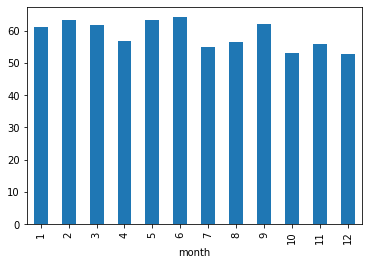

In [12]:
new_df.groupby('month').score.mean().plot.bar()

#### The average search score almost remains same for all the months

<AxesSubplot:xlabel='year'>

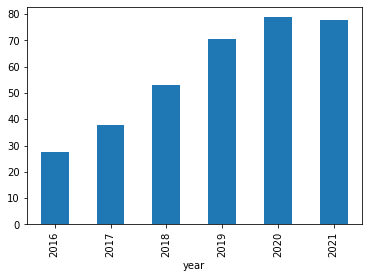

In [13]:
new_df.groupby('year').score.mean().plot.bar()

#### There is a clear upward trend of search scores from 2016 to 2020. 2021 looks almost similar to 2020.

In [14]:
new_df

,week,score,year,month,day
week,,,,,
2016-07-10,2016-07-10,26,2016,7,10
2016-07-17,2016-07-17,30,2016,7,17
2016-07-24,2016-07-24,24,2016,7,24
2016-07-31,2016-07-31,22,2016,7,31
2016-08-07,2016-08-07,21,2016,8,7
...,...,...,...,...,...
2021-06-06,2021-06-06,86,2021,6,6
2021-06-13,2021-06-13,75,2021,6,13
2021-06-20,2021-06-20,79,2021,6,20


#### Plot the time series

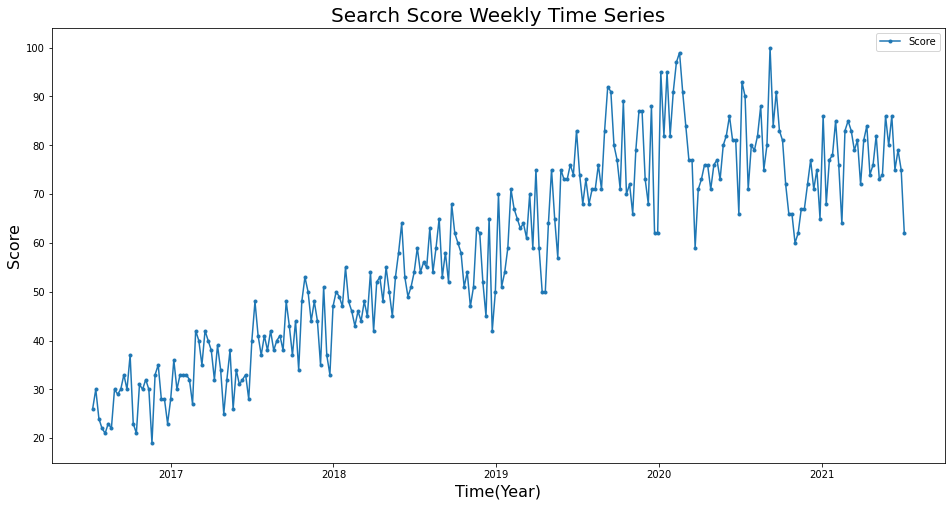

In [15]:
plt.figure(figsize=(16,8))

plt.plot(new_df['score'], ".-", label = 'Score')

plt.title('Search Score Weekly Time Series', fontsize=20)
plt.xlabel("Time(Year)", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.legend(loc = 'best')


##### There is a clear upward trend from 2016 to 2020 and then the plot stabilizes 

## 3. Modelling

##### Since the weekly time series looks bit noisy, let us aggregate and convert it to a monthly series

In [64]:
monthly = new_df.resample('M').sum()
monthly

,score,year,month,day
week,,,,
2016-07-31,102,8064,28,82
2016-08-31,96,8064,32,70
2016-09-30,122,8064,36,58
2016-10-31,142,10080,50,80
2016-11-30,114,8064,44,66
...,...,...,...,...
2021-03-31,315,8084,12,70
2021-04-30,315,8084,16,58
2021-05-31,395,10105,25,80


In [17]:
start_date = datetime(2016,7,31)
end_date = datetime(2021,7,31)

#### Plot the monthly score

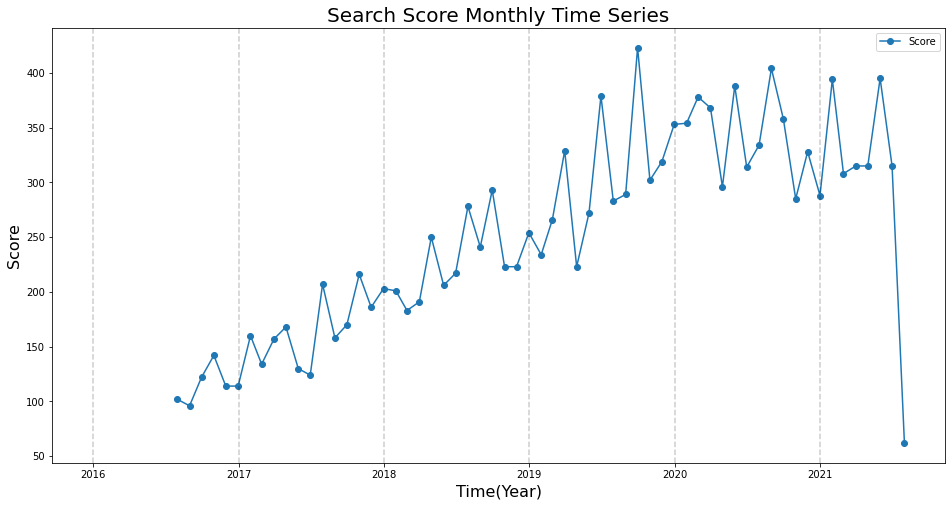

In [18]:
plt.figure(figsize=(16,8))

plt.plot(monthly['score'], "o-", label = 'Score')

plt.title('Search Score Monthly Time Series', fontsize=20)
plt.xlabel("Time(Year)", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.legend(loc = 'best')

for year in range(start_date.year,end_date.year+1):
   plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


We see some seasonal patterns in the time series and an upward trend till 2019 end which flattens after that. 

#### For simplicity, let us take a limited data from 1-1-2017 till 1-1-2020.

In [19]:
#lim_data = new_df['2016-07-10': '2017-06-18']

start_date = datetime(2017,1,1)
end_date = datetime(2020,1,1)

lim_data = monthly[start_date:end_date]
len(lim_data)

36

In [20]:
lim_data

,score,year,month,day
week,,,,
2017-01-31,160,10085,5,75
2017-02-28,134,8068,8,62
2017-03-31,157,8068,12,62
2017-04-30,168,10085,20,80
2017-05-31,130,8068,20,70
2017-06-30,124,8068,24,58
2017-07-31,207,10085,35,80
2017-08-31,158,8068,32,66
2017-09-30,170,8068,36,54


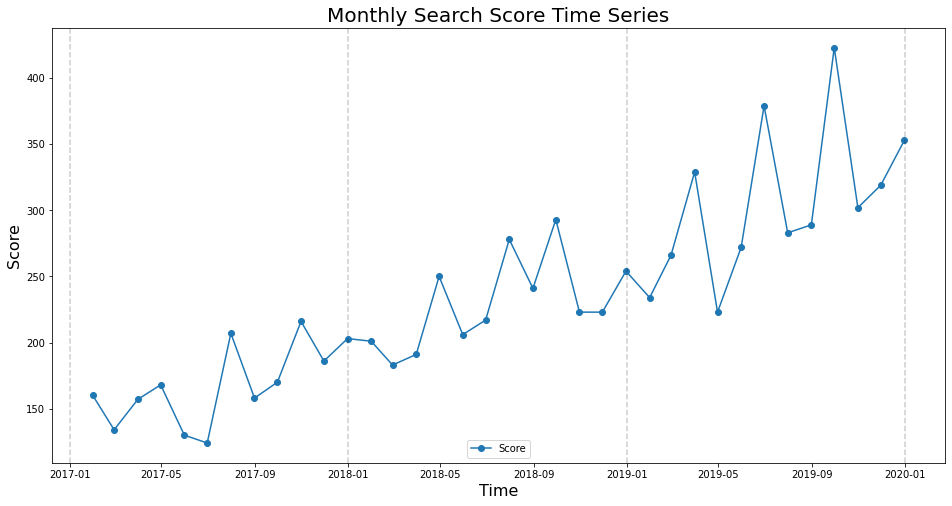

In [21]:
plt.figure(figsize=(16,8))

plt.plot(lim_data['score'], "o-", label = 'Score')

plt.title('Monthly Search Score Time Series', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.legend(loc = 'best')

for year in range(start_date.year,end_date.year+1):
   plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Since we see an upward trend in the time series, it is not stationary.

##### A time series is stationary if it satisfies the following three conditions.

1. Mean of the series over time is constant
2. Variance of the series over time is constant.
3. No seasonality.

##### Classic Time series modelling techniques like AR(Auto Regression), MA(Moving Average), ARMA (AR + MA) won't work if there is stationarity in the time series. 

We have to check for the stationarity of the series by
1. Visually inspecting the plot as above.
2. Advanced test methodologies like Dickey Fuller test as we do below.


### 3.1 DF Test

In [22]:
# DF Test using statsmodels adfuller
from statsmodels.tsa.stattools import adfuller

def df_test(time_series):
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    
    print (dfoutput)

In [23]:
df_test(lim_data.score)

Results of Dickey-Fuller Test:
Test Statistic                 -0.384395
p-value                         0.912672
#Lags Used                      2.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


p-value is 0.91 which is significantly high than the expected ( <0.05). 
According to DF test, the null hypothesis is that the time series is not stationary. A high p-value supports the null hypothesis.

##### So this proves our time series is not stationary.


##### We have to make the time series stationary by first removing the trend.
We can do this by differencing technique. This technique takes the difference between the value at a time step and it's value at previous time step.

For example, first order differencing is subtracting value at time step (t) and value at time step (t-1).




### 3.2 First order differencing

In [24]:
print(list(lim_data.score))

[160, 134, 157, 168, 130, 124, 207, 158, 170, 216, 186, 203, 201, 183, 191, 250, 206, 217, 278, 241, 293, 223, 223, 254, 234, 266, 329, 223, 272, 379, 283, 289, 423, 302, 319, 353]


In [25]:
first_diff = lim_data.score.diff()[1:]

print(list(first_diff))

[-26.0, 23.0, 11.0, -38.0, -6.0, 83.0, -49.0, 12.0, 46.0, -30.0, 17.0, -2.0, -18.0, 8.0, 59.0, -44.0, 11.0, 61.0, -37.0, 52.0, -70.0, 0.0, 31.0, -20.0, 32.0, 63.0, -106.0, 49.0, 107.0, -96.0, 6.0, 134.0, -121.0, 17.0, 34.0]


#### Plot the first difference

No handles with labels found to put in legend.


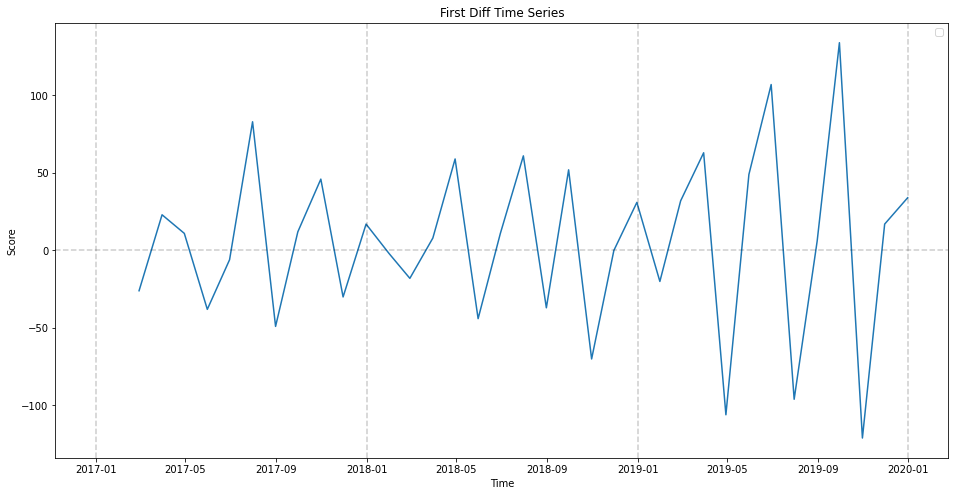

In [26]:
plt.figure(figsize=(16,8))

plt.plot(first_diff)

plt.title('First Diff Time Series')
plt.xlabel("Time")
plt.ylabel("Score")
plt.legend(loc = 'best')

for year in range(start_date.year,end_date.year+1):
   plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

The first differenced series looks to have constant mean and variance though the variance is not perfectly constant.<br>
Let's try DF test on this data.

In [27]:
df_test(first_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.294180e+01
p-value                        3.521882e-24
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


##### The p-value is significantly less value now indicating that the differenced time series is stationary.

##### Let us break both the original and first differenced time series in to trend, seasonality and residuals (noise component) and analyze.

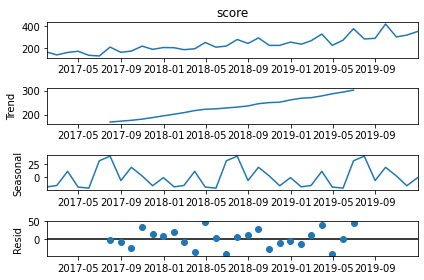

In [28]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(lim_data.score).plot()
plt.show()

We see the upward trend and a clear seasonality (repeating pattern) in the original time series. The residuals look normally distributed around zero which is fine.

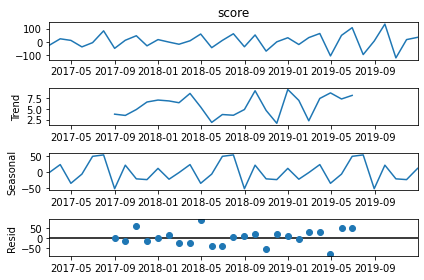

In [29]:
sm.tsa.seasonal_decompose(first_diff).plot()
plt.show()

We see no trend (expected), but a clear seasonality (repeating pattern) in the "first difference" series. The residuals look normally distributed around zero which is fine.

Since we see both seasonality and trend in the original time series 

#### We will use SARIMA algorithm which stands for Seasonal ARIMA ( Seasonal Auto Regressive Integrated Moving Average )

SARIMA is a variation of ARIMA ( which in turn is combination of AR and MA along with a I which stands for Integrated )


It has Parameters - Non-seasonal (p,d,q) and Seasonal (P,D,Q,m).

We can break SARIMA in to 

1. Seasonality - The algorithm takes in to consideration the seasonality of the time series via some parameters (P,D,Q,m).<br><br>

2. AR - Auto Regressive - This forecasting method assumes that the value at any time step t can be calculated as a regression involving one or more previous time steps' values of the same time series (this is referred as Auto - i.e. previous values of it's own ).
The number of these time steps is referred as AR lags (denoted by p parameter ).

3. I - Integrated : Differencing is done for removing the trend and to achieve stationarity. The order of differencing is given by parameter d. In our case, d=1 as we do first difference.

4. MA - Moving Average - This forecasting method assumes that the value at any time step t can be calculated as a regression involving the errors seen at that time step and previous time steps. The number of these time steps is referred as MA lags (denoted by q parameter ).

The parameters (P,D,Q) are seasonal counterparts of p,q and d. 
m is the number of time steps in which there is a repetition of seasonality ( for example, 12 months if one time step is one month and seasonal pattern repeats in duration of one year ). P is the seasonal AR lag, Q is seasonal MA lag, D is seasonal difference order.

From the time series and seasonality plots that we saw earlier, we can observe m = 12 ( One year ).

For determining p and q, we need to plot PACF (Partial Auto Correlation Function ) and ACF ( Auto Correlation Function) respectively which we will do next.



### 3.3 ACF and PACF Analysis 

Plot ACF and PACF on first difference series

#### ACF

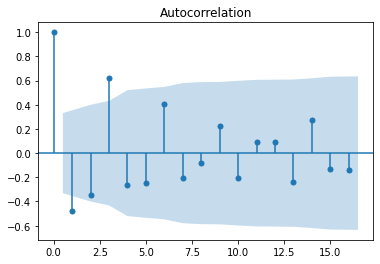

In [30]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(first_diff)

Each stick in the plot corresponds to lags starting from 0 ( which has the maximum correlation of 1 as it is correlation of a time step value with itself ).

From ACF it appears lags 1 (t-1) and 2 (t-2) are significant for MA (q parameter).

#### PACF

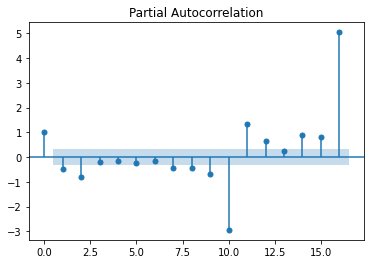

In [31]:
pacf_plot = plot_pacf(first_diff)

Each stick in the plot corresponds to lags starting from 0 ( which has the maximum correlation of 1 as it is correlation of a time step value with itself ).

From PACF it appears lags 1 (t-1) and 2 (t-2) are significant for AR (p parameter). The next lag 10 is too far away, but indicates seasonal pattern.

#### But, before we go further with advanced algorithm , let us build a base line model ( based on Holt Winters algorithm )

### 3.4  Baseline Model - Holt Winters Algorithm 
The idea behind Holt's Winters method is to apply exponential smoothing to the seasonal components in addition to level and trend.

#### Split Train Test data

In [32]:
lim_data

,score,year,month,day
week,,,,
2017-01-31,160,10085,5,75
2017-02-28,134,8068,8,62
2017-03-31,157,8068,12,62
2017-04-30,168,10085,20,80
2017-05-31,130,8068,20,70
2017-06-30,124,8068,24,58
2017-07-31,207,10085,35,80
2017-08-31,158,8068,32,66
2017-09-30,170,8068,36,54


In [33]:
from datetime import timedelta

train_end = datetime(2019,6,30)
test_end = datetime(2019,12,31)

train_data = lim_data[:train_end]
test_data = lim_data[train_end + timedelta(days=1):test_end]

In [34]:
train_data.tail(5)

,score,year,month,day
week,,,,
2019-02-28,266,8076,8,54
2019-03-31,329,10095,15,85
2019-04-30,223,8076,16,70
2019-05-31,272,8076,20,62
2019-06-30,379,10095,30,80


In [35]:
test_data

,score,year,month,day
week,,,,
2019-07-31,283,8076,28,70
2019-08-31,289,8076,32,58
2019-09-30,423,10095,45,75
2019-10-31,302,8076,40,66
2019-11-30,319,8076,44,54
2019-12-31,353,10095,60,75


##### Build Holt Winters model and forecast test data

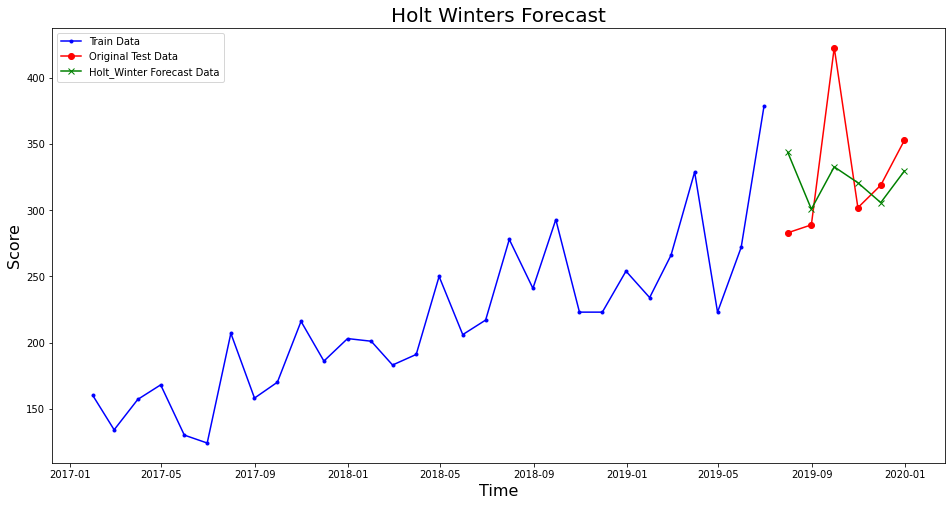

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing


holt_winter = ExponentialSmoothing(np.asarray(train_data['score']), seasonal_periods=12, trend='add', seasonal='add')

hw_fit = holt_winter.fit()

hw_forecast = hw_fit.forecast(len(test_data))

plt.figure(figsize=(16,8))

plt.plot(train_data.index, train_data['score'], "b.-", label='Train Data')
plt.plot(test_data.index, test_data['score'], "ro-", label='Original Test Data')
plt.plot(test_data.index, hw_forecast, "gx-", label='Holt_Winter Forecast Data')
plt.ylabel('Score', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc='best')
plt.title('Holt Winters Forecast', fontsize=20)
plt.show()

In [37]:
list(hw_forecast)

[343.9421124051718,
 300.9036219181998,
 332.8815244618489,
 320.8416381453372,
 305.8270938947398,
 329.7901504976596]

In [38]:
test_data['score']

week
2019-07-31    283
2019-08-31    289
2019-09-30    423
2019-10-31    302
2019-11-30    319
2019-12-31    353
Freq: M, Name: score, dtype: int32

In [39]:
hw_residuals = test_data['score'] - hw_forecast

In [40]:
print('Mean Absolute Percent Error:', round(np.mean(abs(hw_residuals/test_data.score)),2))

Mean Absolute Percent Error: 0.11


###### MAPE of Holt Winters Model is 11%

In [41]:
print('Root Mean Squared Error:', np.sqrt(np.mean(hw_residuals**2)))

Root Mean Squared Error: 46.62654252975711


Let us proceed to build an advanced model based on SARIMA algorithm

### 3.5  Finding the optimum parameters for SARIMA - p,q and P,Q

#### AUTO ARIMA to find optimum p,q and P,Q

We set d=1 (first difference) and D also as 1.

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [42]:
from pmdarima import auto_arima

Sarimax_model = auto_arima(train_data.score,
                       start_p=0,
                       start_q=0,
                       max_p=3,
                       max_q=3,
                       m=12,
                       test='adf',
                       seasonal=True,
                       d=1,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=195.482, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=191.890, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=193.633, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=193.483, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=193.482, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=191.819, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=193.632, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=195.630, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=184.849, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=186.530, Time=0.12 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=186.531, Time=0.13 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=188.530, Time=0.18 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=186.843, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   30
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -89.425
Date:                            Sat, 17 Jul 2021   AIC                            184.849
Time:                                    19:48:26   BIC                            187.349
Sample:                                         0   HQIC                           185.098
                                             - 30                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7468      0.247     -3.023      0.003      -1.231      -0.263
ar.L2         -0.7369      0.201     -3.668      0.000      -1.131      -0.343
sigma2      1959.1808    961.963      2.037      0.042      73.769    3844.593
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.77   Prob(JB):                         0.58
Heteroskedasticity (H):               3.85   Skew:                            -0.59
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### The best model chosen by Auto ARIMA is <br> 

Best model:  ARIMA(2,1,0)(0,1,0)[12] 

p=2
d=1
q=0

P=0
D=1
Q=0
m=12

Let us use these parameter values to SARIMA model as below. 

### 3.6  SARIMA Model Training & Forecast

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

my_order = (2,1,0)

my_seasonal_order = (0, 1, 0, 12)

# define model
model = SARIMAX(train_data.score, order=my_order, seasonal_order=my_seasonal_order)

In [44]:
#fit the model
model_fit = model.fit()

In [45]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              score   No. Observations:                   30
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -89.425
Date:                            Sat, 17 Jul 2021   AIC                            184.849
Time:                                    19:48:26   BIC                            187.349
Sample:                                01-31-2017   HQIC                           185.098
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7468      0.247     -3.023      0.003      -1.231      -0.263
ar.L2         -0.7369      0.201   

##### Forecast the data for the corresponding test time steps

In [46]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data.score))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data.score - predictions

##### Plot the residuals in the predicted test data 

In [47]:
residuals

week
2019-07-31   -16.772849
2019-08-31    -7.758825
2019-09-30    -3.708406
2019-10-31    28.551273
2019-11-30    40.809730
2019-12-31   -14.002126
Freq: M, dtype: float64

Text(0, 0.5, 'Error')

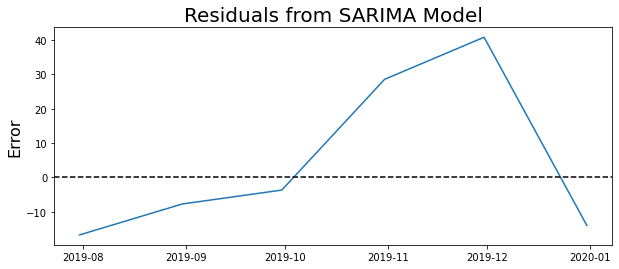

In [48]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [49]:
residuals.mean()

4.519799727967931

##### Ideally residuals should have mean as 0, but we see it is 4.5 which is not bad..

In [50]:
predictions

week
2019-07-31    299.772849
2019-08-31    296.758825
2019-09-30    426.708406
2019-10-31    273.448727
2019-11-30    278.190270
2019-12-31    367.002126
Freq: M, Name: predicted_mean, dtype: float64

##### Plot Train data, Test data and predictions of the test data 

Text(0.5, 0, 'Time')

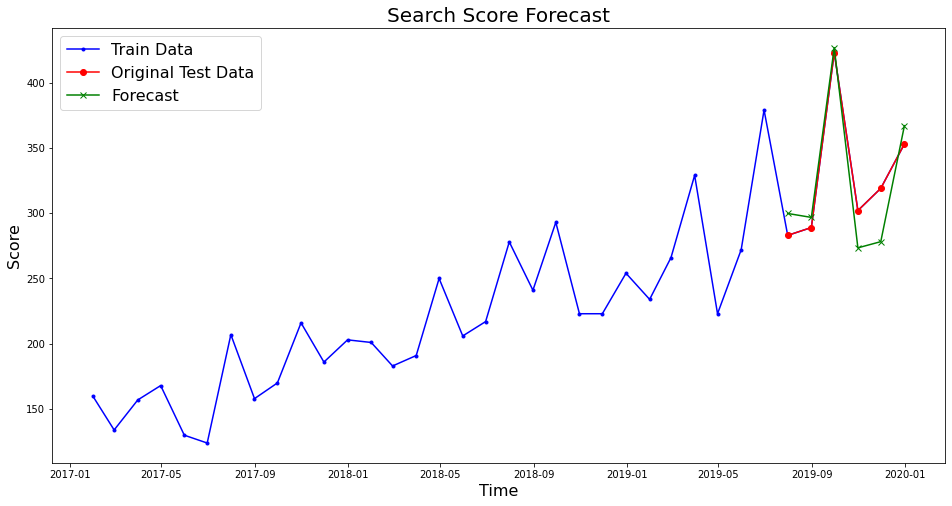

In [51]:
plt.figure(figsize=(16,8))

plt.plot(lim_data.score, "b.-")
plt.plot(test_data.score, "ro-")
plt.plot(predictions, "gx-")

plt.legend(('Train Data', 'Original Test Data', 'Forecast'), fontsize=16)

plt.title('Search Score Forecast', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Time', fontsize=16)

#for year in range(start_date.year,end_date.year):
 #   plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Forecast predictions look nice and fairly close to the shape of the original time series !!

##### MAPE estimation

In [52]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.score)),3))

Mean Absolute Percent Error: 0.06


##### We get MAPE of nearly 6% which is much better than the baseline model which gave 11%.

In [53]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 22.479431030281887


In [54]:
test_data.score

week
2019-07-31    283
2019-08-31    289
2019-09-30    423
2019-10-31    302
2019-11-30    319
2019-12-31    353
Freq: M, Name: score, dtype: int32

In [55]:
predictions

week
2019-07-31    299.772849
2019-08-31    296.758825
2019-09-30    426.708406
2019-10-31    273.448727
2019-11-30    278.190270
2019-12-31    367.002126
Freq: M, Name: predicted_mean, dtype: float64

### 3.7  Rolling Forecast

Here we forecast time steps one by one by training on all it's previous time steps.

For example, 
we first train on the actual data of t time steps and forecast data for t+1.
Then we train on the actual data of t+1 time steps and forecast data for t+2.
And so on..


In [56]:
print(test_data.index)
train_data.shape

DatetimeIndex(['2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='week', freq='M')


(30, 4)

In [57]:
rolling_predictions = []

for train_end in test_data.index:
    #print(train_end-timedelta(days=1))
    train_data1 = lim_data.score[:train_end-timedelta(days=1)]
    #print(len(train_data1))
    model = SARIMAX(train_data1, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions.append(pred[0])
    
rolling_predictions = pd.Series(rolling_predictions, index=test_data.index)
rolling_predictions

week
2019-07-31    299.772849
2019-08-31    294.811662
2019-09-30    429.103582
2019-10-31    256.552418
2019-11-30    278.709646
2019-12-31    373.826110
Freq: M, dtype: float64

In [58]:
rolling_residuals = test_data.score - rolling_predictions
rolling_residuals

week
2019-07-31   -16.772849
2019-08-31    -5.811662
2019-09-30    -6.103582
2019-10-31    45.447582
2019-11-30    40.290354
2019-12-31   -20.826110
Freq: M, dtype: float64

Text(0, 0.5, 'Error')

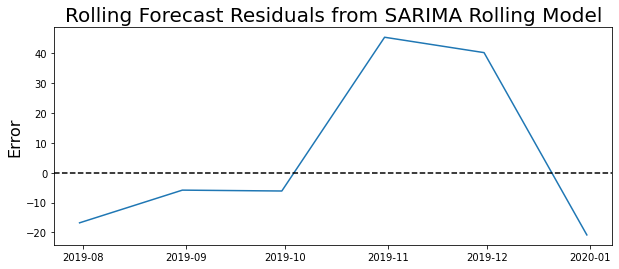

In [59]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Rolling Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [60]:
rolling_residuals.mean()

6.037288858044718

Text(0.5, 0, 'Time')

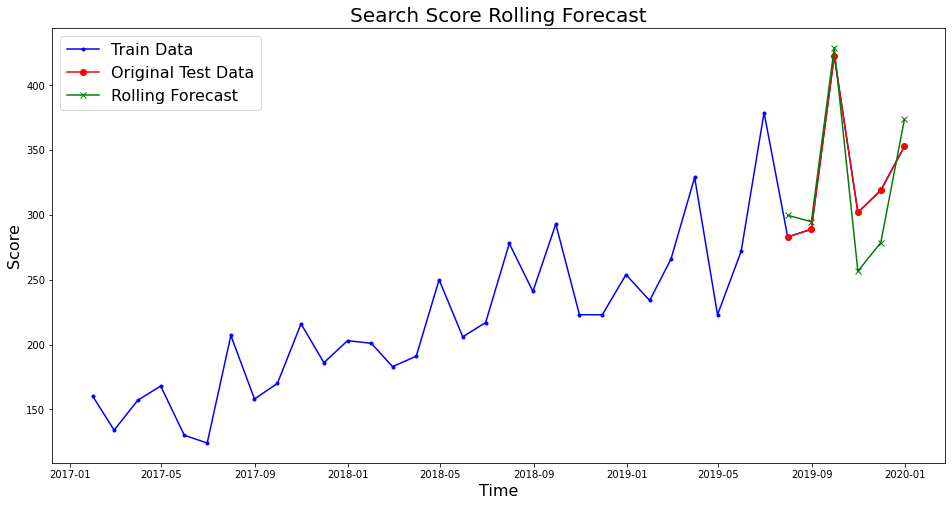

In [61]:
   
plt.figure(figsize=(16,8))

plt.plot(lim_data.score, "b.-")
plt.plot(test_data.score, "ro-")
plt.plot(rolling_predictions, "gx-")

plt.legend(('Train Data', 'Original Test Data', 'Rolling Forecast'), fontsize=16)

plt.title('Search Score Rolling Forecast', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Time', fontsize=16)

In [62]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data.score)),2))

Mean Absolute Percent Error: 0.07


##### We get MAPE of nearly 7% which is slightly less than the earlier model.

In [63]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 27.30958232232495
